# `PHAS0102 Assignment 2 - solving two 1D problems - part one`

In [1]:
%matplotlib widget

In [1]:
import matplotlib.pyplot as plt
import numba
from numba import jit, njit, prange, cuda
import numpy as np
from scipy import sparse
from timeit import timeit
from tqdm import tqdm

## `part 1: solving a wave problem with sparse matrices`

We want to compute the solution to the following time-harmonic wave problem:  
$$\frac{d^2u}{dx^2} + k^2 u = 0 \qquad \text{in (0,1),}$$
$$u=0 \qquad \text{if } x=0,$$
$$u=1 \qquad \text{if } x=1$$
with wavenumber $k = 29\pi/2$.  

We can approximately solve this problem with the method of finite differences. This involves taking evenly spaced values $x_0=0,x_1,x_2,...,x_N=1$ and approximating the value of $u$ for each value: we will call these approximations $u_i$. To compute these approximations, we use:
$$\frac{d^2u_i}{dx^2} \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{h^2}$$  
where $h = 1/N$.  

The problem can be rewritten as the matrix-vector problem 
$\mathbf{A}\mathbf{u} = \mathbf{f}$, where $\mathbf{A}$ is a known matrix, $\mathbf{f}$ is a known vector, 
and $\mathbf{u}$ is an unknown vector that we want to compute.  
The entries of $\mathbf{f}$ and $\mathbf{u}$ are given by  

$$
[\mathbf{u}]_i = u_i
$$
$$
[\mathbf{f}]_i =
\begin{cases}
1, & \text{if } i = N, \\[0.5em]
0, & \text{otherwise.}
\end{cases}
$$

The rows of $\mathbf{A}$ are given by  

$$
[\mathbf{A}]_{i,j} =
\begin{cases}
1, & \text{if } i = j, \\[0.5em]
0, & \text{otherwise,}
\end{cases}
$$

if $i = 0$ or $i = N$; and  

$$
[\mathbf{A}]_{i,j} =
\begin{cases}
2 - h^2 k^2, & \text{if } j = i, \\[0.5em]
-1, & \text{if } j = i + 1, \\[0.5em]
-1, & \text{if } j = i - 1, \\[0.5em]
0, & \text{otherwise,}
\end{cases}
$$
otherwise.

### `1a`
The function below takes $N$ as an input and returns the matrix $\textbf{A}$ in CSR format, and the vector $\textbf{f}$.

In [2]:
def sparse_CSR(N):
    """
    description:
        constructing matrix and vector in COO (coordinate list) form, and then converting into CSR (compressed sparse row) storage
    input:
        N: number of points in system, int
    outputs:
        A: sparse matrix, CSR format, numpy.array
        f: sparse vector, numpy.array
    """
    # constants
    k = 29 * np.pi / 2
    h = 1. / N

    # intialise matrix arrays in COO form
    data, rows, cols = [], [], []

    # initialise vector
    f = np.zeros(N+1)

    # boundary conditions
    data.append(1.)
    rows.append(0)
    cols.append(0)

    # interior data
    for i in range(1, N):
        data.append(-1.)
        rows.append(i)
        cols.append(i-1)

        data.append(2. - h**2 * k**2)
        rows.append(i)
        cols.append(i)

        data.append(-1.)
        rows.append(i)
        cols.append(i+1)

    # boundary conditions
    data.append(1.)
    rows.append(N)
    cols.append(N)

    f[-1] = 1.

    # converting to CSR form
    A = sparse.csr_matrix((data, (rows, cols)), shape=(N+1, N+1))
    
    return A, f

### `1b`
Using the functiion `scipy.sparse.linalg.spsolve`, approximate solutions to the matrix problem $\textbf{Au}=\textbf{f}$ can be computed for various $N$. These solutions are then plotted against the true solution: $$u_{exact}(x) = \text{sin}(kx)$$ One can expect that the $N=1000$ solution will be the closest to the actual solution, as with increasing $N$, $h$ tends to 0, replicating the non-discrete limit. Correspondingly, the $N=10$ and $N=100$ solutions will be less accurate.

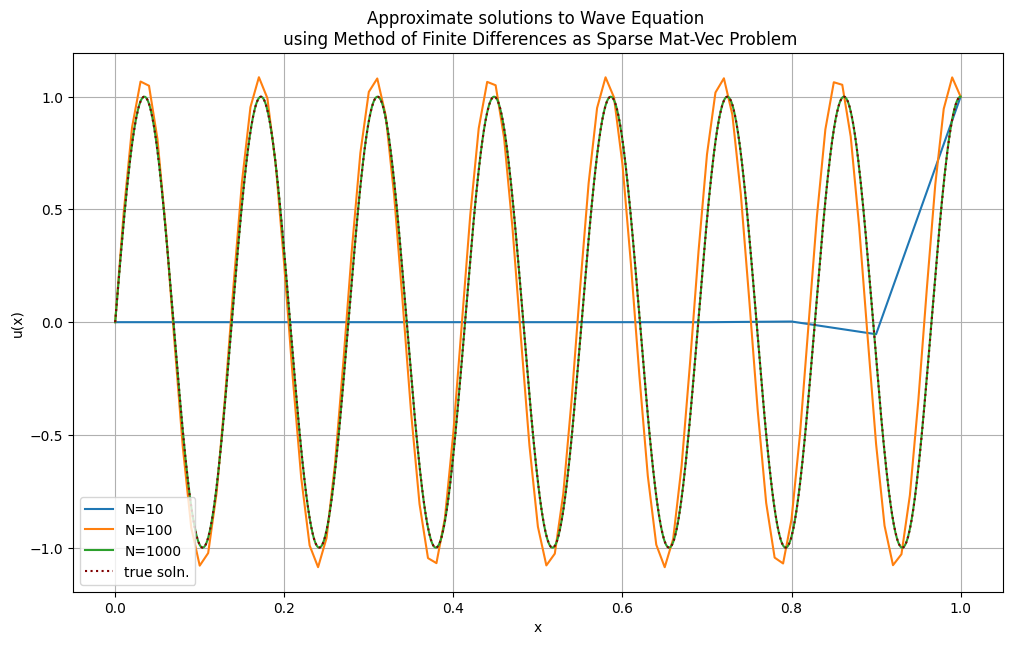

In [3]:
plt.figure(figsize=(12,7))

for N in [10,100,1000]:
    A, f = sparse_CSR(N)
    solution = sparse.linalg.spsolve(A, f)
    line = np.linspace(0,1,len(solution))

    plt.plot(line, solution, label=f'N={N}')

x = np.linspace(0,1,1000)
k = 29*np.pi/2
plt.plot(x,np.sin(k*x), ls='dotted', label='true soln.', color='maroon')

plt.title('Approximate solutions to Wave Equation \n using Method of Finite Differences as Sparse Mat-Vec Problem')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid()
plt.legend()
plt.show()

As can be seen, the $N=1000$ case is the most accurate to the true solution.

### `1c`
A possible approximate measure of error in the solution can found by computing: $$\textbf{max}_i |u_i - u_{exact}(x_i)|$$ This error will be plotted on log scales for a range of $N$. For the same range of N, the approximation computation time for the function will be measured and plotted.

In [4]:
# initialising storage lists
errors = []
computation_times = []
N_range = np.arange(1e3, 1e6, 1e4)

for N in tqdm(N_range):
    A, f = sparse_CSR(int(N))
    solution = sparse.linalg.spsolve(A, f)
    time = timeit(lambda:sparse.linalg.spsolve(A,f), number=5)

    x = np.linspace(0,1,len(solution))
    exact_solution = np.sin(k*x)

    errors.append(np.max(np.abs(solution-exact_solution)))
    computation_times.append(time/5)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.02s/it]


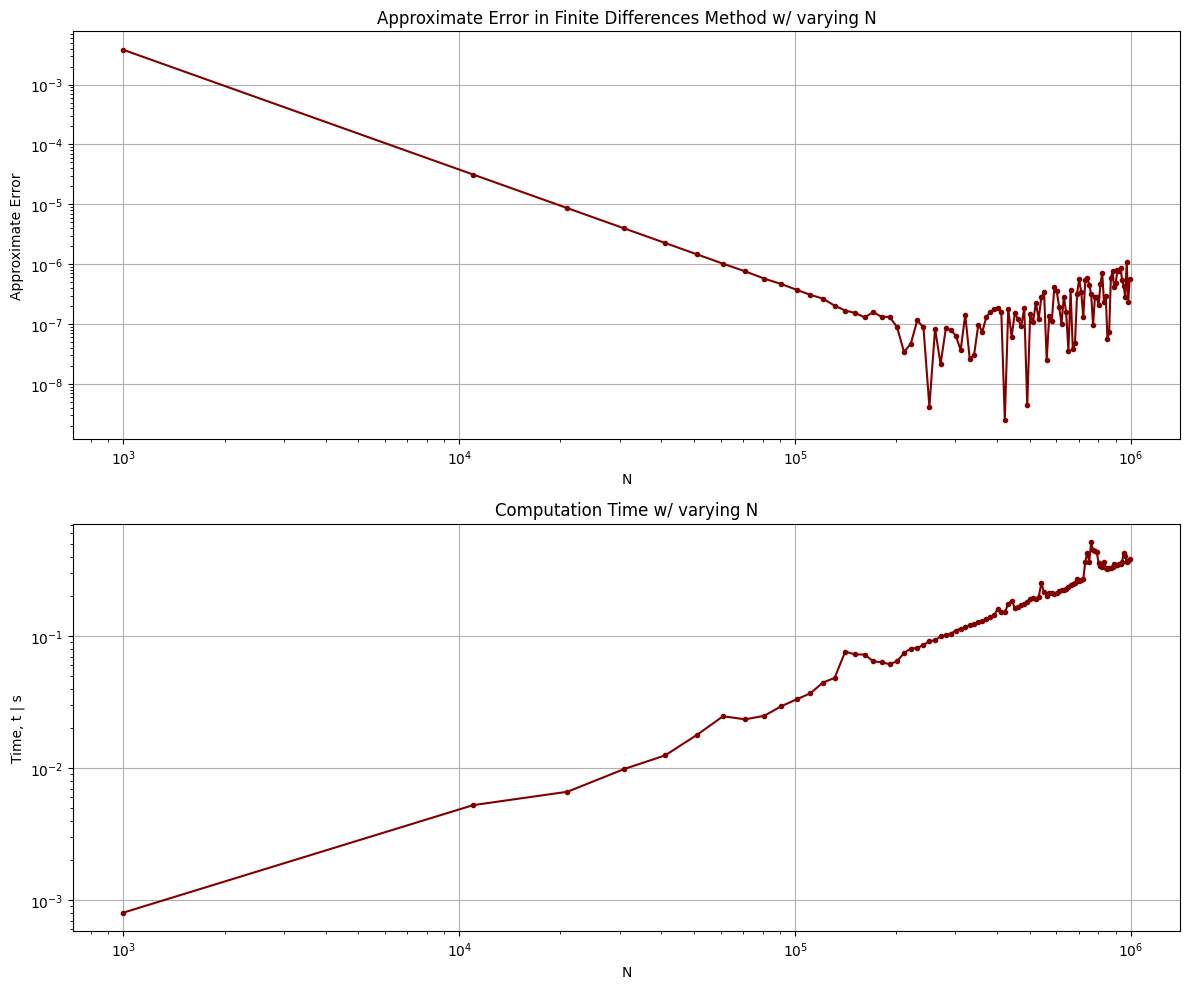

In [7]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1) 
plt.plot(N_range, errors, '.-', color='maroon')
plt.title('Approximate Error in Finite Differences Method w/ varying N')
plt.xlabel('N')
plt.ylabel('Approximate Error')

plt.grid()
plt.xscale('log')
plt.yscale('log')


plt.subplot(2, 1, 2)
plt.plot(N_range, computation_times, '.-', color='maroon')
plt.title('Computation Time w/ varying N')
plt.xlabel('N')
plt.ylabel('Time, t | s')

plt.grid()
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

The ideal approximate solution will have error below $10^{-8}$. To find a value of N that will return the best error, the above tests will be carried out over a restricted range of N, between $2\times10^5$ and $10^6$.

In [8]:
# initialising storage lists
restricted_errors = []
restricted_computation_times = []
restricted_N_range = [int(N) for N in np.linspace(2e5, 1e6, 150)]

In [9]:
for N in tqdm(restricted_N_range):
    A, f = sparse_CSR(int(N))
    solution = sparse.linalg.spsolve(A, f)
    time = timeit(lambda:sparse.linalg.spsolve(A,f), number=5)

    x = np.linspace(0,1,len(solution))
    exact_solution = np.sin(k*x)

    restricted_errors.append(np.max(np.abs(solution-exact_solution)))
    restricted_computation_times.append(time/5)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [06:41<00:00,  2.67s/it]


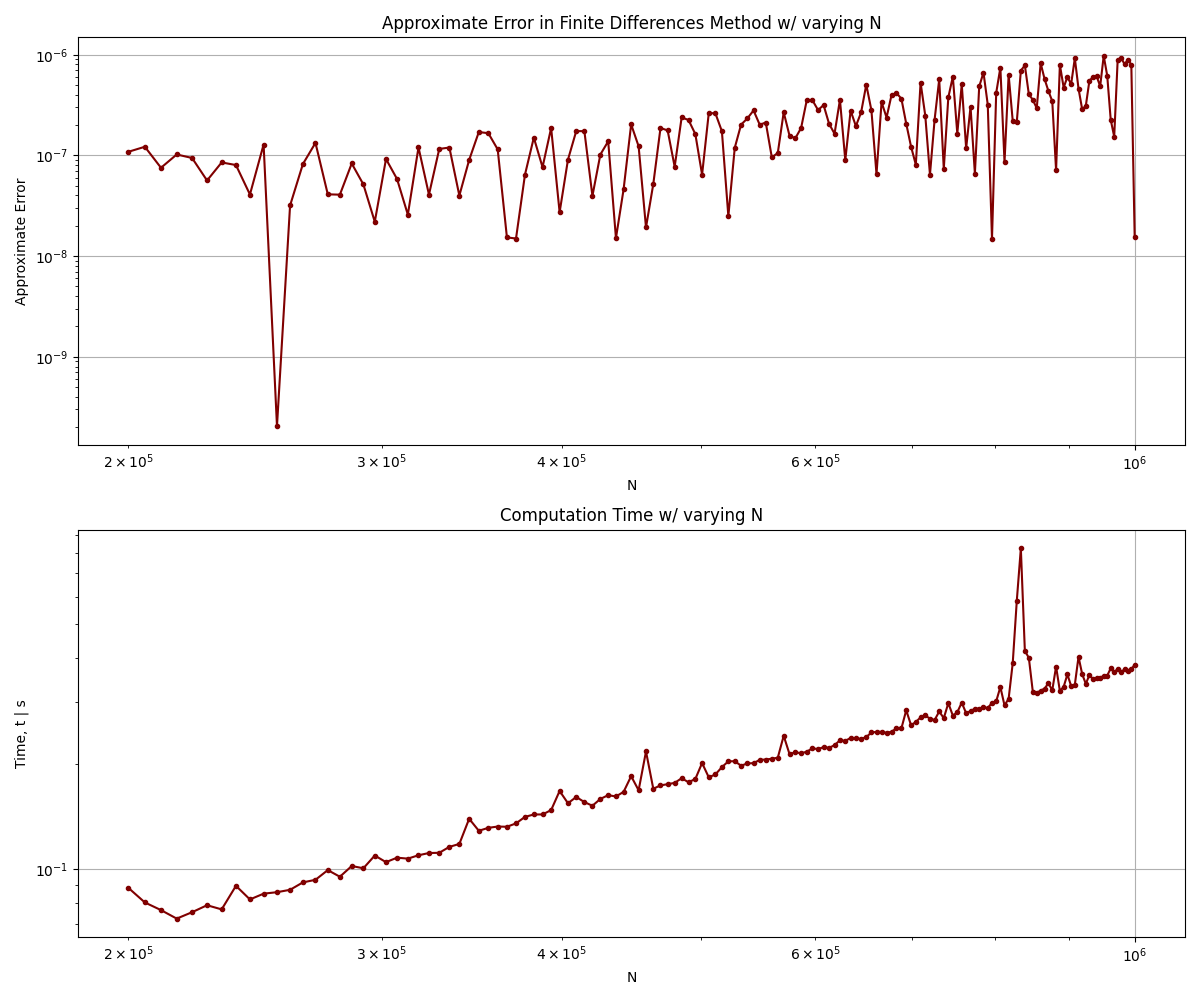

In [10]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1) 
plt.plot(restricted_N_range, restricted_errors, '.-', color='maroon')
plt.title('Approximate Error in Finite Differences Method w/ varying N')
plt.xlabel('N')
plt.ylabel('Approximate Error')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.subplot(2, 1, 2)
plt.plot(restricted_N_range, restricted_computation_times, '.-', color='maroon')
plt.title('Computation Time w/ varying N')
plt.xlabel('N')
plt.ylabel('Time, t | s')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

Using the `%matplotlib.notebook widget` tool, we can zoom in on the lowest error and obtain and value of $N=253691$, returning an error of roughly $2 \cdot 10^{-10}$. The associated computation time is predicted to be roughly 0.08-0.09 seconds.

In [18]:
est_N_optimal = 253691

In [22]:
est_A_optimal, est_f_optimal = sparse_CSR(int(est_N_optimal))
est_optimal_time = timeit(lambda:sparse.linalg.spsolve(est_A_optimal, est_f_optimal), number=100)/100

est_optimal_solution = sparse.linalg.spsolve(est_A_optimal, est_f_optimal)
x = np.linspace(0,1,len(est_optimal_solution))
exact_solution = np.sin(k*x)
approx_error = np.max(np.abs(est_optimal_solution-exact_solution))

In [23]:
print(f'time taken       : {est_optimal_time:3f}s')
print(f'associated error : {approx_error:3g}')

time taken       : 0.090757s
associated error : 2.05003e-10


As predicted, our error is below $10^{-8}$ and computation time roughly 0.09s. Alternatively, one can make use of the `numpy.argmin` function to find the parameters exactly. They match our estimated values well.

In [24]:
min_index = np.argmin([error for error in restricted_errors if error < 1e-8])
error_optimal, time_optimal, N_optimal = [(error, time, N) for error, time, N in zip(restricted_errors, restricted_computation_times, restricted_N_range) if error < 1e-8][min_index]
print(f'optimal paramater values are:')
print(f'    N                 =  {N_optimal}')
print(f'    computation time  =  {time_optimal}')
print(f'    approximate error =  {error_optimal}')

optimal paramater values are:
    N                 =  253691
    computation time  =  0.08607957999920472
    approximate error =  2.0500250108579365e-10
